# Robust Conformal Prediction under Distributional Shift
## Author : Darshit Shah

## Project Overview
This project evaluates conformal prediction methods when the exchangeability
assumption between calibration and test data is violated by distributional shift.
We study classical, robust, weighted, and fine-grained conformal approaches and
analyze how coverage and interval efficiency change as shift severity increases.

---

## Dataset and Shift Design
- Dataset: Communities & Crime (normalized), regression target
  `ViolentCrimesPerPop`
- Source vs. target domains are constructed using a domain feature
- Two regimes are considered:
  - Mild shift (weakly target-correlated feature)
  - Severe shift (strongly target-correlated feature)

---

## Evaluation Approach
- Target coverage: 90% (α = 0.1)
- Robustness parameter ρ swept across multiple values
- 30 repeated trials with fixed domain split and randomized calibration splits
- Metrics:
  - Empirical target-domain coverage
  - Average prediction interval length
  - Binwise conditional coverage diagnostics


## 1) Setup

In [1]:

import numpy as np
import pandas as pd
import glob, os, warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")
np.set_printoptions(precision=4, suppress=True)

os.makedirs("figures", exist_ok=True)


## 2) Load dataset (local CSV/XLSX) + detect target

In [2]:

files = sorted(glob.glob("crime_data_normalized.xlsx")) + sorted(glob.glob("data/*.csv"))
if not files:
    raise FileNotFoundError("No dataset found. Put the Communities & Crime file in ./data/ as .csv or .xlsx")

path = files[0]
print("Using:", path)

df = pd.read_excel(path, engine="openpyxl") if path.lower().endswith(".xlsx") else pd.read_csv(path)
df = df.select_dtypes(include=[np.number]).copy()

# Detect target
cols_lower = {c.lower(): c for c in df.columns}
target = cols_lower.get("violentcrimesperpop", None)
if target is None:
    cands = [c for c in df.columns if ("violent" in c.lower() and "pop" in c.lower())]
    if not cands:
        raise ValueError("Could not detect ViolentCrimesPerPop. Set `target` manually.")
    target = cands[0]

y = df[target].astype(float).values
X = df.drop(columns=[target]).values
feature_names = df.drop(columns=[target]).columns.tolist()

print("Target:", target)
print("X shape:", X.shape, "y shape:", y.shape, "y min/max:", float(np.nanmin(y)), float(np.nanmax(y)))


Using: crime_data_normalized.xlsx
Target: ViolentCrimesPerPop
X shape: (1994, 101) y shape: (1994,) y min/max: 0.0 1.0


## 3) Helpers: preprocessing, domain split, weights, quantiles, robust mapping

In [ ]:

def make_preprocess(use_pca=True, pca_var=0.95):
    steps = [
        ("imputer", SimpleImputer(strategy="median")),
        ("power", PowerTransformer(method="yeo-johnson")),
        ("scaler", StandardScaler()),
    ]
    if use_pca:
        steps.append(("pca", PCA(n_components=pca_var, random_state=0)))
    return Pipeline(steps)

def safe_corr(x, y):
    x = pd.Series(x).fillna(pd.Series(x).median()).values
    y = pd.Series(y).fillna(pd.Series(y).median()).values
    if np.std(x) < 1e-12 or np.std(y) < 1e-12:
        return 0.0
    return float(np.corrcoef(x, y)[0,1])

def choose_domain_feature(X, y, feature_names, mode="lowcorr"):
    X_df = pd.DataFrame(X, columns=feature_names)
    abs_corr = X_df.apply(lambda c: abs(safe_corr(c.values, y)))
    if mode == "topcorr":
        return abs_corr.sort_values(ascending=False).index[0], abs_corr
    elif mode == "lowcorr":
        # pick from bottom 20% abs corr, choose highest variance among them
        cutoff = np.quantile(abs_corr.values, 0.20)
        candidates = abs_corr[abs_corr <= cutoff].index.tolist()
        if not candidates:
            candidates = abs_corr.sort_values().index[:min(10, len(abs_corr))].tolist()
        vars_ = X_df[candidates].var(numeric_only=True).sort_values(ascending=False)
        return vars_.index[0], abs_corr
    else:
        raise ValueError("mode must be 'lowcorr' or 'topcorr'")

def split_source_target(X, y, feature_names, mode="lowcorr"):
    feat, abs_corr = choose_domain_feature(X, y, feature_names, mode=mode)
    X_df = pd.DataFrame(X, columns=feature_names)
    dom_vals = X_df[feat].fillna(X_df[feat].median()).values
    thr = np.median(dom_vals)
    src = dom_vals <= thr
    tgt = dom_vals > thr
    info = {
        "domain_feat": feat,
        "abs_corr_domain_y": float(abs_corr[feat]),
        "thr": float(thr),
        "src_n": int(src.sum()),
        "tgt_n": int(tgt.sum())
    }
    return X[src], y[src], X[tgt], y[tgt], dom_vals[tgt], info

def estimate_odds_weights(prep, X_src_for_w, X_tgt_for_w, X_query, seed=0):
    X_all = np.vstack([X_src_for_w, X_tgt_for_w])
    d = np.hstack([np.zeros(len(X_src_for_w)), np.ones(len(X_tgt_for_w))])

    clf = Pipeline([
        ("prep", prep),
        ("lr", LogisticRegression(max_iter=3000, random_state=seed))
    ])
    clf.fit(X_all, d)
    p = clf.predict_proba(X_query)[:,1]
    p = np.clip(p, 1e-4, 1-1e-4)
    return p/(1-p)

def clip_weights(w_cal, w_x, q=0.99):
    cap = np.quantile(np.r_[w_cal, w_x], q)
    return np.clip(w_cal, 0, cap), np.clip(w_x, 0, cap), float(cap)

def weighted_quantile(values, weights, q):
    q = float(np.clip(q, 0.0, 1.0))
    idx = np.argsort(values)
    v = values[idx]
    w = weights[idx]
    cw = np.cumsum(w) / np.sum(w)
    j = np.searchsorted(cw, q, side="left")
    return v[min(j, len(v)-1)]

def f_kl(t):
    if t <= 0:
        return 0.0
    return t*np.log(t)

def g_f_rho(beta, rho, iters=60):
    beta = float(np.clip(beta, 1e-12, 1-1e-12))
    lo, hi = 0.0, beta
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        val = beta*f_kl(mid/beta) + (1-beta)*f_kl((1-mid)/(1-beta))
        if val <= rho:
            hi = mid
        else:
            lo = mid
    return hi

def g_inv_f_rho(tau, rho, iters=60):
    tau = float(np.clip(tau, 0.0, 1.0))
    lo, hi = 0.0, 1.0
    for _ in range(iters):
        mid = 0.5*(lo+hi)
        if g_f_rho(mid, rho) <= tau:
            lo = mid
        else:
            hi = mid
    return lo


## 4) Conformal intervals: CP, RCP, WCP, WRCP + fine-grained Cluster-CP/Cluster-RCP
Fine-grained approach: cluster calibration points, then compute **cluster-specific** quantiles.

In [4]:

def intervals_cp(scores, mu_test, alpha, res_scale=1.0):
    n = len(scores)
    q_level = np.ceil((n+1)*(1-alpha)) / n
    q_level = min(q_level, 1.0)
    qhat = np.quantile(scores, q_level)
    return mu_test - qhat*res_scale, mu_test + qhat*res_scale

def intervals_rcp(scores, mu_test, alpha, rho, res_scale=1.0):
    beta = g_inv_f_rho(1-alpha, rho=rho)
    n = len(scores)
    p_inf = 1.0/(n+1)
    if beta > (1-p_inf):
        return np.full(len(mu_test), -np.inf), np.full(len(mu_test), np.inf)
    qhat = np.quantile(scores, beta/(1-p_inf))
    return mu_test - qhat*res_scale, mu_test + qhat*res_scale

def intervals_wcp(scores, mu_test, w_cal, alpha, res_scale=1.0):
    qhat = weighted_quantile(scores, w_cal, 1-alpha)
    return mu_test - qhat*res_scale, mu_test + qhat*res_scale

def intervals_wrcp(scores, mu_test, w_cal, w_x, alpha, rho, res_scale=1.0):
    beta = g_inv_f_rho(1-alpha, rho=rho)
    lo = np.empty(len(mu_test))
    hi = np.empty(len(mu_test))
    for j in range(len(mu_test)):
        denom = np.sum(w_cal) + w_x[j]
        p_inf = w_x[j] / denom
        if beta > (1-p_inf):
            lo[j], hi[j] = -np.inf, np.inf
        else:
            # weights on scores from calibration (normalized)
            p_scores = w_cal / denom
            qhat = weighted_quantile(scores, p_scores, beta/(1-p_inf))
            lo[j], hi[j] = mu_test[j] - qhat*res_scale, mu_test[j] + qhat*res_scale
    return lo, hi

def coverage_and_length(lo, hi, y):
    cov = np.mean((y >= lo) & (y <= hi))
    length = np.mean(hi - lo)
    return float(cov), float(length)

# Fine-grained: clustered local calibration
def fit_clusters(prep, X_fit, X_cal, X_tgt, n_clusters=8, seed=0):
    # Fit on preprocessed source-fit only
    Z_fit = prep.fit_transform(X_fit)
    Z_cal = prep.transform(X_cal)
    Z_tgt = prep.transform(X_tgt)
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10)
    km.fit(Z_fit)
    return km.predict(Z_cal), km.predict(Z_tgt)

def intervals_cluster_cp(scores, mu_test, alpha, cal_cluster, tgt_cluster, res_scale=1.0, min_cal=50):
    lo = np.empty(len(mu_test))
    hi = np.empty(len(mu_test))
    # global fallback
    glo_lo, glo_hi = intervals_cp(scores, mu_test, alpha, res_scale=res_scale)
    for j in range(len(mu_test)):
        idx = np.where(cal_cluster == tgt_cluster[j])[0]
        if len(idx) < min_cal:
            lo[j], hi[j] = glo_lo[j], glo_hi[j]
        else:
            q = np.quantile(scores[idx], 1-alpha)
            lo[j], hi[j] = mu_test[j] - q*res_scale, mu_test[j] + q*res_scale
    return lo, hi

def intervals_cluster_rcp(scores, mu_test, alpha, rho, cal_cluster, tgt_cluster, res_scale=1.0, min_cal=50):
    lo = np.empty(len(mu_test))
    hi = np.empty(len(mu_test))
    glo_lo, glo_hi = intervals_rcp(scores, mu_test, alpha, rho, res_scale=res_scale)
    beta = g_inv_f_rho(1-alpha, rho=rho)
    for j in range(len(mu_test)):
        idx = np.where(cal_cluster == tgt_cluster[j])[0]
        if len(idx) < min_cal:
            lo[j], hi[j] = glo_lo[j], glo_hi[j]
        else:
            n = len(idx)
            p_inf = 1.0/(n+1)
            if beta > (1-p_inf):
                lo[j], hi[j] = -np.inf, np.inf
            else:
                q = np.quantile(scores[idx], beta/(1-p_inf))
                lo[j], hi[j] = mu_test[j] - q*res_scale, mu_test[j] + q*res_scale
    return lo, hi


## 5) One experiment run function (supports two shifts + ablation toggles)

In [ ]:

def run_experiment(
    split_mode="lowcorr",
    use_pca=True,
    use_residual_scaling=True,
    alpha=0.1,
    rhos=(0.0, 0.01, 0.02, 0.05, 0.10),
    R=20,
    n_clusters=8,
    weight_clip_q=0.99,
    seed0=0
):
    rows = []
    # Create a domain split once (same partition strategy across repeats)
    X_src, y_src, X_tgt, y_tgt, dom_vals_tgt, info = split_source_target(X, y, feature_names, mode=split_mode)

    for seed in range(seed0, seed0 + R):
        X_fit, X_cal, y_fit, y_cal = train_test_split(X_src, y_src, test_size=0.5, random_state=seed)

        prep = make_preprocess(use_pca=use_pca, pca_var=0.95)

        # Base regressor
        model = Pipeline([
            ("prep", prep),
            ("lasso", LassoCV(cv=5, random_state=0, n_jobs=-1))
        ])
        model.fit(X_fit, y_fit)

        mu_cal = model.predict(X_cal)
        mu_tgt = model.predict(X_tgt)
        residuals_cal = y_cal - mu_cal

        res_scale = float(np.std(residuals_cal)) if use_residual_scaling else 1.0
        if res_scale < 1e-12:
            res_scale = 1.0

        scores = np.abs(residuals_cal) / res_scale

        # weights for WCP/WRCP (stabilized)
        w_cal = estimate_odds_weights(prep, X_fit, X_tgt, X_cal, seed=seed)
        w_x   = estimate_odds_weights(prep, X_fit, X_tgt, X_tgt, seed=seed)
        w_cal, w_x, cap = clip_weights(w_cal, w_x, q=weight_clip_q)

        # clusters for fine-grained methods (use a fresh preprocess copy to avoid leakage issues)

        cal_cluster, tgt_cluster = fit_clusters(make_preprocess(use_pca=use_pca, pca_var=0.95), X_fit, X_cal, X_tgt, n_clusters=n_clusters, seed=seed)

        for rho in rhos:
            lo_cp, hi_cp = intervals_cp(scores, mu_tgt, alpha, res_scale=res_scale)
            lo_rcp, hi_rcp = intervals_rcp(scores, mu_tgt, alpha, rho, res_scale=res_scale)
            lo_wcp, hi_wcp = intervals_wcp(scores, mu_tgt, w_cal, alpha, res_scale=res_scale)
            lo_wrcp, hi_wrcp = intervals_wrcp(scores, mu_tgt, w_cal, w_x, alpha, rho, res_scale=res_scale)

            lo_ccp, hi_ccp = intervals_cluster_cp(scores, mu_tgt, alpha, cal_cluster, tgt_cluster, res_scale=res_scale)
            lo_crcp, hi_crcp = intervals_cluster_rcp(scores, mu_tgt, alpha, rho, cal_cluster, tgt_cluster, res_scale=res_scale)

            methods = {
                "CP": (lo_cp, hi_cp),
                "RCP": (lo_rcp, hi_rcp),
                "WCP": (lo_wcp, hi_wcp),
                "WRCP": (lo_wrcp, hi_wrcp),
                "Cluster-CP": (lo_ccp, hi_ccp),
                "Cluster-RCP": (lo_crcp, hi_crcp),
            }

            for m, (lo, hi) in methods.items():
                cov, length = coverage_and_length(lo, hi, y_tgt)
                rows.append({
                    "split_mode": split_mode,
                    "domain_feat": info["domain_feat"],
                    "abs_corr_domain_y": info["abs_corr_domain_y"],
                    "use_pca": use_pca,
                    "use_residual_scaling": use_residual_scaling,
                    "rho": rho,
                    "seed": seed,
                    "method": m,
                    "coverage": cov,
                    "avg_length": length,
                    "weight_cap": cap,
                    "n_clusters": n_clusters
                })

    res = pd.DataFrame(rows)
    summary = res.groupby(["split_mode","use_pca","use_residual_scaling","rho","method"]).agg(
        coverage_mean=("coverage","mean"),
        coverage_se=("coverage", lambda x: x.std(ddof=1)/np.sqrt(len(x))),
        length_mean=("avg_length","mean"),
        length_se=("avg_length", lambda x: x.std(ddof=1)/np.sqrt(len(x)))
    ).reset_index()

    return res, summary, info, dom_vals_tgt, y_tgt


## 6) Run the **two shift regimes** (mild vs severe)

In [6]:

alpha = 0.1
rhos = [0.0, 0.01, 0.02, 0.05, 0.10]
R = 30

# Mild shift: low-correlation domain feature
raw_mild, summ_mild, info_mild, dom_tgt_mild, y_tgt_mild = run_experiment(
    split_mode="lowcorr", use_pca=True, use_residual_scaling=True, alpha=alpha, rhos=rhos, R=R, n_clusters=8, weight_clip_q=0.99
)
print("Mild shift domain feature:", info_mild)

# Severe shift: top-correlation domain feature (stress test)
raw_sev, summ_sev, info_sev, dom_tgt_sev, y_tgt_sev = run_experiment(
    split_mode="topcorr", use_pca=True, use_residual_scaling=True, alpha=alpha, rhos=rhos, R=R, n_clusters=8, weight_clip_q=0.99
)
print("Severe shift domain feature:", info_sev)

# Save summaries
summ_mild.to_csv("results_summary_mild.csv", index=False)
summ_sev.to_csv("results_summary_severe.csv", index=False)

summ_mild.head(), summ_sev.head()


Mild shift domain feature: {'domain_feat': 'fold', 'abs_corr_domain_y': 0.03257666142378166, 'thr': 5.0, 'src_n': 999, 'tgt_n': 995}
Severe shift domain feature: {'domain_feat': 'PctKids2Par', 'abs_corr_domain_y': 0.7384238020704452, 'thr': 0.64, 'src_n': 1016, 'tgt_n': 978}


(  split_mode  use_pca  use_residual_scaling  rho       method  coverage_mean  \
 0    lowcorr     True                  True  0.0           CP       0.929715   
 1    lowcorr     True                  True  0.0   Cluster-CP       0.913836   
 2    lowcorr     True                  True  0.0  Cluster-RCP       0.923049   
 3    lowcorr     True                  True  0.0          RCP       0.929514   
 4    lowcorr     True                  True  0.0          WCP       0.930352   
 
    coverage_se  length_mean  length_se  
 0     0.001659     0.494451   0.004186  
 1     0.002047     0.438327   0.003917  
 2     0.002200     0.454320   0.004418  
 3     0.001662     0.493946   0.004207  
 4     0.006425     0.523539   0.021887  ,
   split_mode  use_pca  use_residual_scaling  rho       method  coverage_mean  \
 0    topcorr     True                  True  0.0           CP       0.810464   
 1    topcorr     True                  True  0.0   Cluster-CP       0.637969   
 2    topcorr   

## 7) Plots: Coverage vs ρ and Length vs ρ (mild vs severe)
These are the key figures that directly support the paper’s claim.

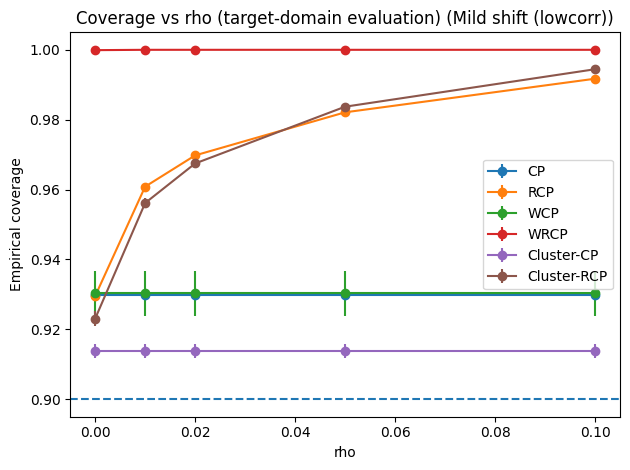

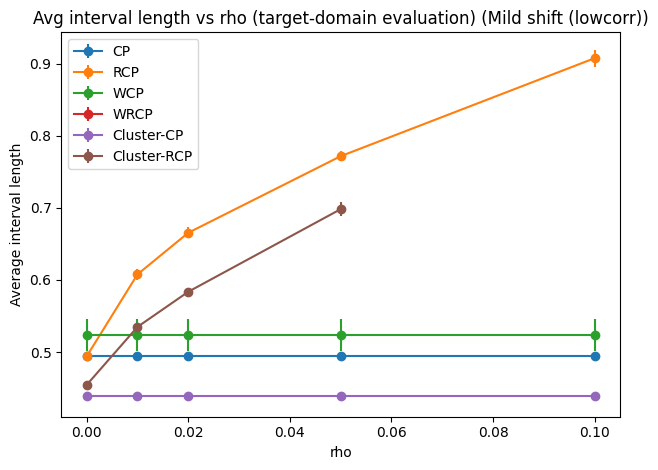

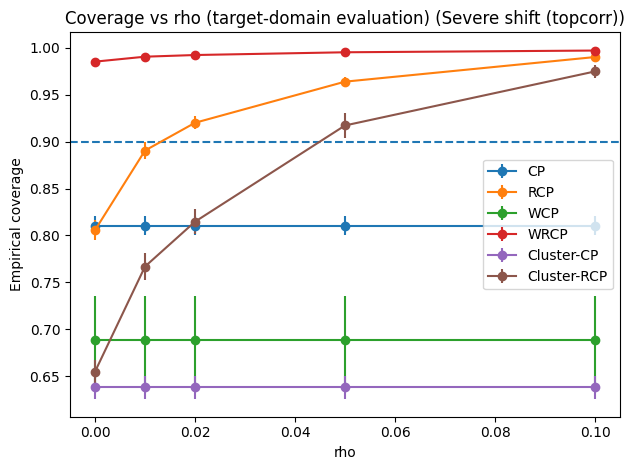

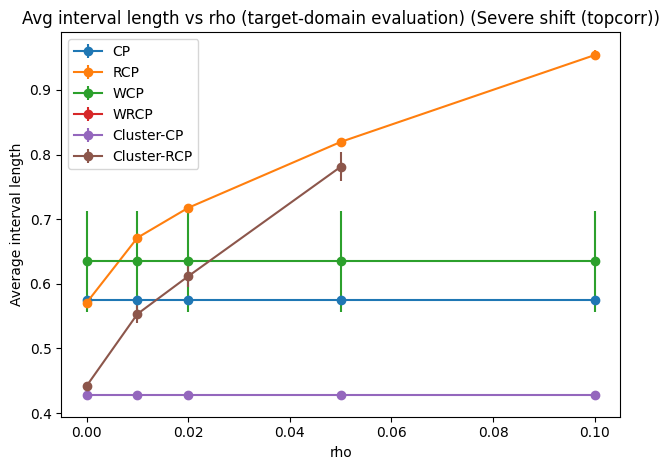

In [7]:

def plot_metric(summary, split_label, metric_col, se_col, title, fname):
    plt.figure()
    methods = ["CP","RCP","WCP","WRCP","Cluster-CP","Cluster-RCP"]
    for m in methods:
        d = summary[summary["method"] == m]
        plt.errorbar(d["rho"], d[metric_col], yerr=d[se_col], marker="o", label=m)
    if metric_col == "coverage_mean":
        plt.axhline(1-alpha, linestyle="--")
    plt.xlabel("rho")
    plt.ylabel("Empirical coverage" if metric_col=="coverage_mean" else "Average interval length")
    plt.title(f"{title} ({split_label})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=220)
    plt.show()

plot_metric(summ_mild, "Mild shift (lowcorr)", "coverage_mean", "coverage_se",
            "Coverage vs rho (target-domain evaluation)", "figures/coverage_vs_rho_mild.png")
plot_metric(summ_mild, "Mild shift (lowcorr)", "length_mean", "length_se",
            "Avg interval length vs rho (target-domain evaluation)", "figures/length_vs_rho_mild.png")

plot_metric(summ_sev, "Severe shift (topcorr)", "coverage_mean", "coverage_se",
            "Coverage vs rho (target-domain evaluation)", "figures/coverage_vs_rho_severe.png")
plot_metric(summ_sev, "Severe shift (topcorr)", "length_mean", "length_se",
            "Avg interval length vs rho (target-domain evaluation)", "figures/length_vs_rho_severe.png")


## 8) Conditional coverage diagnostics (binwise coverage)
This is where you demonstrate ‘fine-grained’ heterogeneity explicitly.
We plot coverage across bins of increasing domain-feature value.

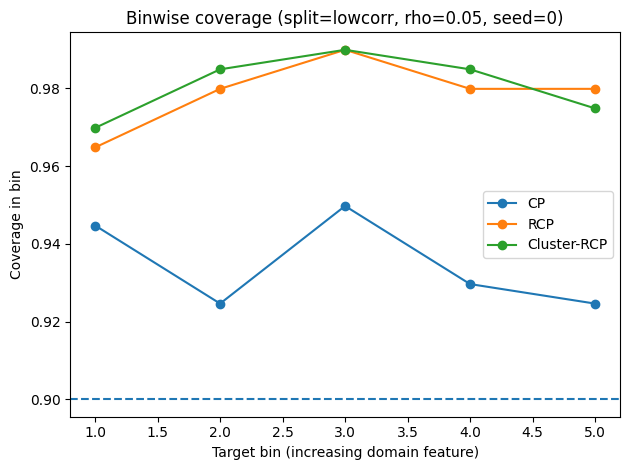

Bin sizes: [199 199 199 199 199]
Bin edges (quantiles): [ 6.   6.8  7.6  8.4  9.2 10. ]
Domain feature: fold | abs corr: 0.03257666142378166


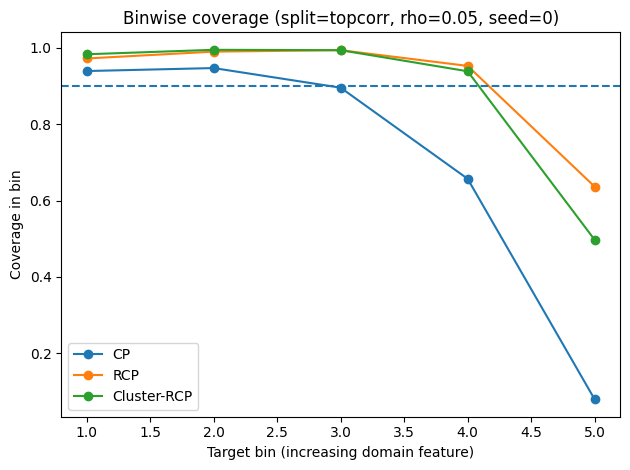

Bin sizes: [182 209 173 213 201]
Bin edges (quantiles): [0.65  0.7   0.758 0.81  0.88  1.   ]
Domain feature: PctKids2Par | abs corr: 0.7384238020704452


In [8]:

def binwise_coverage(lo, hi, y, dom_vals, n_bins=5):
    qs = np.quantile(dom_vals, np.linspace(0, 1, n_bins+1))
    covs = []
    ns = []
    for b in range(n_bins):
        mask = (dom_vals >= qs[b]) & ((dom_vals <= qs[b+1]) if b==n_bins-1 else (dom_vals < qs[b+1]))
        ns.append(int(mask.sum()))
        if mask.sum() == 0:
            covs.append(np.nan)
        else:
            covs.append(float(np.mean((y[mask] >= lo[mask]) & (y[mask] <= hi[mask]))))
    return np.array(covs), np.array(ns), qs

# Illustrative single seed for each shift regime
def illustrative_binwise(raw_df, split_mode, rho, seed):
    sub = raw_df[(raw_df["split_mode"]==split_mode) & (raw_df["rho"]==rho) & (raw_df["seed"]==seed)]
    # We need to recompute intervals for that seed to get lo/hi arrays (raw_df stores only aggregate stats).
    # So we do a small re-run for a single seed with the same settings.
    X_src, y_src, X_tgt, y_tgt, dom_vals_tgt, info = split_source_target(X, y, feature_names, mode=split_mode)
    X_fit, X_cal, y_fit, y_cal = train_test_split(X_src, y_src, test_size=0.5, random_state=seed)

    prep = make_preprocess(use_pca=True, pca_var=0.95)
    model = Pipeline([("prep", prep), ("lasso", LassoCV(cv=5, random_state=0, n_jobs=-1))])
    model.fit(X_fit, y_fit)

    mu_cal = model.predict(X_cal)
    mu_tgt = model.predict(X_tgt)
    residuals_cal = y_cal - mu_cal
    res_scale = float(np.std(residuals_cal))
    if res_scale < 1e-12:
        res_scale = 1.0
    scores = np.abs(residuals_cal) / res_scale

    w_cal = estimate_odds_weights(prep, X_fit, X_tgt, X_cal, seed=seed)
    w_x   = estimate_odds_weights(prep, X_fit, X_tgt, X_tgt, seed=seed)
    w_cal, w_x, _ = clip_weights(w_cal, w_x, q=0.99)

    cal_cluster, tgt_cluster = fit_clusters(make_preprocess(use_pca=True, pca_var=0.95), X_fit, X_cal, X_tgt, n_clusters=8, seed=seed)

    lo_cp, hi_cp = intervals_cp(scores, mu_tgt, alpha, res_scale=res_scale)
    lo_rcp, hi_rcp = intervals_rcp(scores, mu_tgt, alpha, rho, res_scale=res_scale)
    lo_crcp, hi_crcp = intervals_cluster_rcp(scores, mu_tgt, alpha, rho, cal_cluster, tgt_cluster, res_scale=res_scale)

    # Binwise
    cp_bins, ns, qs = binwise_coverage(lo_cp, hi_cp, y_tgt, dom_vals_tgt)
    rcp_bins, _, _  = binwise_coverage(lo_rcp, hi_rcp, y_tgt, dom_vals_tgt)
    crcp_bins, _, _ = binwise_coverage(lo_crcp, hi_crcp, y_tgt, dom_vals_tgt)

    plt.figure()
    plt.plot(range(1,6), cp_bins, marker="o", label="CP")
    plt.plot(range(1,6), rcp_bins, marker="o", label="RCP")
    plt.plot(range(1,6), crcp_bins, marker="o", label="Cluster-RCP")
    plt.axhline(1-alpha, linestyle="--")
    plt.xlabel("Target bin (increasing domain feature)")
    plt.ylabel("Coverage in bin")
    plt.title(f"Binwise coverage (split={split_mode}, rho={rho}, seed={seed})")
    plt.legend()
    plt.tight_layout()
    out = f"figures/binwise_{split_mode}_rho{rho}.png".replace(".","p")
    plt.savefig(out, dpi=220)
    plt.show()

    print("Bin sizes:", ns)
    print("Bin edges (quantiles):", qs)
    print("Domain feature:", info["domain_feat"], "| abs corr:", info["abs_corr_domain_y"])

illustrative_binwise(raw_mild, "lowcorr", rho=0.05, seed=0)
illustrative_binwise(raw_sev, "topcorr", rho=0.05, seed=0)


## 9) Small ablation: with vs without PCA and residual scaling (mild shift)
This is a simple, high-value sanity check that boosts credibility.

In [9]:

ablations = [
    (True, True),
    (True, False),
    (False, True),
    (False, False),
]

abl_summaries = []
for use_pca, use_rs in ablations:
    _, summ, info, _, _ = run_experiment(
        split_mode="lowcorr",
        use_pca=use_pca,
        use_residual_scaling=use_rs,
        alpha=alpha,
        rhos=rhos,
        R=15,
        n_clusters=8,
        weight_clip_q=0.99
    )
    summ["ablation"] = f"PCA={use_pca},ResScale={use_rs}"
    abl_summaries.append(summ)

abl = pd.concat(abl_summaries, ignore_index=True)
abl.to_csv("results_summary_ablation_mild.csv", index=False)

# Quick view for rho=0.05
abl[(abl["rho"]==0.05) & (abl["method"].isin(["CP","RCP","Cluster-RCP"]))][
    ["ablation","method","coverage_mean","length_mean"]
].sort_values(["ablation","method"])


,ablation,method,coverage_mean,length_mean
108,"PCA=False,ResScale=False",CP,0.930184,0.495537
110,"PCA=False,ResScale=False",Cluster-RCP,0.982446,0.692056
111,"PCA=False,ResScale=False",RCP,0.982781,0.773262
78,"PCA=False,ResScale=True",CP,0.930184,0.495537
80,"PCA=False,ResScale=True",Cluster-RCP,0.982446,0.692056
81,"PCA=False,ResScale=True",RCP,0.982781,0.773262
48,"PCA=True,ResScale=False",CP,0.927504,0.489881
50,"PCA=True,ResScale=False",Cluster-RCP,0.984121,0.696667
51,"PCA=True,ResScale=False",RCP,0.981776,0.767623
18,"PCA=True,ResScale=True",CP,0.927504,0.489881
